In [1]:
%%writefile vectorAdd_stream.cu
#include <stdio.h>
#include <stdlib.h>
#include <cstdio>
#include <cuda_runtime.h>
#include <chrono>

// Define the number of streams we will use for concurrency
#define NUM_STREAMS 4
// Default segment size: 128MB per segment (32M elements)
#define S_SEG_DEFAULT (32 * 1024 * 1024)

#define CHECK(call) do {                                 \
    cudaError_t err = (call);                            \
    if (err != cudaSuccess) {                            \
        std::fprintf(stderr, "CUDA error: %s (%s:%d)\n", \
                     cudaGetErrorString(err), __FILE__, __LINE__); \
        std::exit(1);                                    \
    }                                                    \
} while (0)

/* Our over-simplified CUDA kernel */
/* Parallel vector add kernel: c[i] = a[i] + b[i] for i < n */
__global__ void add(const int *a, const int *b, int *c, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        c[idx] = a[idx] + b[idx];
    }
}

int main(int argc, char **argv) {
    // Problem size (can be overridden by command-line)
    int N = 1 << 20; // default 1,048,576 elements
    int S_seg = S_SEG_DEFAULT;

    if (argc > 1) {
        int v = atoi(argv[1]);
        if (v > 0) N = v;
    }
    if (argc > 2) {
        int v = atoi(argv[2]);
        if (v > 0) S_seg = v;
    }
    if (S_seg > N) S_seg = N; // Ensure segment size doesn't exceed N

    size_t bytes_total = (size_t)N * sizeof(int);
    size_t bytes_seg = (size_t)S_seg * sizeof(int);

    int num_segments = (N + S_seg - 1) / S_seg;

    // --- 1. Allocate PINNED Host Memory ---
    // Pinned memory is required for cudaMemcpyAsync to be truly asynchronous.
    int *h_a, *h_b, *h_c;
    CHECK(cudaHostAlloc((void**)&h_a, bytes_total, cudaHostAllocDefault));
    CHECK(cudaHostAlloc((void**)&h_b, bytes_total, cudaHostAllocDefault));
    // h_c only needs to store the final result
    CHECK(cudaHostAlloc((void**)&h_c, bytes_total, cudaHostAllocDefault));

    // Initialize host data
    for (int i = 0; i < N; ++i) {
        h_a[i] = i;
        h_b[i] = 2 * i;
        h_c[i] = 0; // Clear result buffer
    }

    // --- 2. Allocate Device Memory (4 buffers for concurrent processing) ---
    // We allocate 4 smaller device buffers, one for each stream's active segment.
    int *d_a[NUM_STREAMS], *d_b[NUM_STREAMS], *d_c[NUM_STREAMS];
    for (int i = 0; i < NUM_STREAMS; ++i) {
        // Only allocate segment size (S_seg) in the device buffers
        CHECK(cudaMalloc((void **)&d_a[i], bytes_seg));
        CHECK(cudaMalloc((void **)&d_b[i], bytes_seg));
        CHECK(cudaMalloc((void **)&d_c[i], bytes_seg));
    }

    // --- 3. Create CUDA Streams ---
    cudaStream_t streams[NUM_STREAMS];
    for (int i = 0; i < NUM_STREAMS; ++i) {
        CHECK(cudaStreamCreate(&streams[i]));
    }

    // --- Setup Timing Events ---
    cudaEvent_t start_evt, stop_evt;
    CHECK(cudaEventCreate(&start_evt));
    CHECK(cudaEventCreate(&stop_evt));

    printf("\nStream: Configuration: N=%d, Segment Size (S_seg)=%d, Num Segments=%d, Num Streams=%d\n",
           N, S_seg, num_segments, NUM_STREAMS);

    // --- START CONCURRENT EXECUTION ---
    CHECK(cudaEventRecord(start_evt, 0));

    // --- 4. Asynchronous Loop for Segmented Processing ---
    // We cycle through segments, assigning work to streams in a round-robin fashion.
    for (int i = 0; i < num_segments; ++i) {
        int stream_idx = i % NUM_STREAMS; // Cycle stream indices: 0, 1, 2, 3, 0, 1, ...

        // Calculate the starting index for this segment
        size_t offset = (size_t)i * S_seg;

        // Calculate the actual number of elements in this segment (last segment may be smaller)
        int seg_N = (i == num_segments - 1) ? (N - offset) : S_seg;
        size_t seg_bytes = (size_t)seg_N * sizeof(int);

        // --- 4a. Asynchronous Host-to-Device Copy (H2D) ---
        // Copies h_a[offset] into d_a[stream_idx] on the specified stream.
        CHECK(cudaMemcpyAsync(d_a[stream_idx], h_a + offset, seg_bytes, cudaMemcpyHostToDevice, streams[stream_idx]));
        CHECK(cudaMemcpyAsync(d_b[stream_idx], h_b + offset, seg_bytes, cudaMemcpyHostToDevice, streams[stream_idx]));

        // --- 4b. Launch Kernel (Computation) ---
        int tpb = 128;
        int blocks = (seg_N + tpb - 1) / tpb;

        // Kernel launch is inherently asynchronous. It uses the specified stream.
        add<<<blocks, tpb, 0, streams[stream_idx]>>>(d_a[stream_idx], d_b[stream_idx], d_c[stream_idx], seg_N);
        CHECK(cudaGetLastError()); // Check for kernel launch errors immediately

        // --- 4c. Asynchronous Device-to-Host Copy (D2H) ---
        // Copies d_c[stream_idx] back into h_c[offset] on the specified stream.
        CHECK(cudaMemcpyAsync(h_c + offset, d_c[stream_idx], seg_bytes, cudaMemcpyDeviceToHost, streams[stream_idx]));
    }
    //

    // --- 5. Synchronize All Streams ---
    // The host must wait for ALL operations across ALL streams to finish.
    for (int i = 0; i < NUM_STREAMS; ++i) {
        CHECK(cudaStreamSynchronize(streams[i]));
    }

    CHECK(cudaEventRecord(stop_evt, 0));
    CHECK(cudaEventSynchronize(stop_evt));

    // --- 6. Print Timings and Throughput ---
    float gpu_ms = 0.0f;
    CHECK(cudaEventElapsedTime(&gpu_ms, start_evt, stop_evt));

    // Check a few spots to ensure the result is non-zero (i.e., the kernel ran)
    int validation_error = 0;
    if (h_c[N / 2] != (N / 2) + 2 * (N / 2)) {
        printf("Validation error: h_c[%d] = %d, expected %d\n", N / 2, h_c[N / 2], 3 * (N / 2));
        validation_error = 1;
    } else {
        printf("Quick check at index %d: h_c[%d] = %d. Seems OK.\n", N / 2, N / 2, h_c[N / 2]);
    }

    double gpu_s = (double)gpu_ms / 1000.0;
    // Data processed: 2 inputs (h_a, h_b) + 1 output (h_c). All transfers are overlapping.
    double bytes_transferred_total = 3.0 * bytes_total;
    double gpu_gb_s = bytes_transferred_total / (gpu_s * 1e9);
    double gpu_melems_s = (double)N / (gpu_s * 1e6);

    printf("Execution Time: %.3f ms, Throughput: %.3f GB/s (%.3f Melem/s)\n", gpu_ms, gpu_gb_s, gpu_melems_s);

    // --- 7. Cleanup ---
    for (int i = 0; i < NUM_STREAMS; ++i) {
        CHECK(cudaFree(d_a[i]));
        CHECK(cudaFree(d_b[i]));
        CHECK(cudaFree(d_c[i]));
        CHECK(cudaStreamDestroy(streams[i]));
    }

    CHECK(cudaFreeHost(h_a));
    CHECK(cudaFreeHost(h_b));
    CHECK(cudaFreeHost(h_c));

    CHECK(cudaEventDestroy(start_evt));
    CHECK(cudaEventDestroy(stop_evt));

    return (validation_error == 0) ? 0 : 2;
}

Writing vectorAdd_stream.cu


In [2]:
%%writefile vectorAdd.cu
#include <stdio.h>
#include <stdlib.h>
#include <cstdio>
#include <cuda_runtime.h>
#include <chrono>

#define CHECK(call) do {                                 \
    cudaError_t err = (call);                            \
    if (err != cudaSuccess) {                            \
        std::fprintf(stderr, "CUDA error: %s (%s:%d)\n", \
                     cudaGetErrorString(err), __FILE__, __LINE__); \
        std::exit(1);                                    \
    }                                                    \
} while (0)

/* Our over-simplified CUDA kernel */
/* Parallel vector add kernel: c[i] = a[i] + b[i] for i < n */
__global__ void add(const int *a, const int *b, int *c, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        c[idx] = a[idx] + b[idx];
    }
}

int main(int argc, char **argv) {
    // Problem size (can be overridden by command-line)
    int N = 1 << 20; // default 1,048,576 elements
    if (argc > 1) {
        int v = atoi(argv[1]);
        if (v > 0) N = v;
    }

    size_t bytes = (size_t)N * sizeof(int);

    // Allocate in host memory and initialize
    int *h_a = (int*)malloc(bytes);
    int *h_b = (int*)malloc(bytes);
    int *h_c = (int*)malloc(bytes);
    if (!h_a || !h_b || !h_c) {
        fprintf(stderr, "Host malloc failed\n");
        return 1;
    }
    for (int i = 0; i < N; ++i) {
        h_a[i] = i;
        h_b[i] = 2*i;
        h_c[i] = 0;
    }

    // Allocate in device memory
    int *d_a = nullptr, *d_b = nullptr, *d_c = nullptr;
    CHECK(cudaMalloc((void **)&d_a, bytes));
    CHECK(cudaMalloc((void **)&d_b, bytes));
    CHECK(cudaMalloc((void **)&d_c, bytes));

    // Invoke the CUDA kernel with GPU timing using CUDA events
    cudaEvent_t start_evt, stop_evt;
    CHECK(cudaEventCreate(&start_evt));
    CHECK(cudaEventCreate(&stop_evt));
    CHECK(cudaEventRecord(start_evt, 0));


    // Copy from host memory to device memory
    CHECK(cudaMemcpy(d_a, h_a, bytes, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_b, h_b, bytes, cudaMemcpyHostToDevice));

    // Initialize thread block and thread grid
    int tpb = 128;
    int blocks = (N + tpb - 1) / tpb;

    // Print launch configuration
    long long total_threads = (long long)blocks * (long long)tpb;
    long long extra_threads = total_threads - (long long)N;
    printf("Configuration: N=%zu, blocks=%d, threads_per_block=%d, total_threads=%lld, extra_threads=%lld\n",
        (size_t)N, blocks, tpb, total_threads, extra_threads);

    add<<<blocks, tpb>>>(d_a, d_b, d_c, N);
    CHECK(cudaGetLastError());
    CHECK(cudaEventRecord(stop_evt, 0));
    CHECK(cudaEventSynchronize(stop_evt));

    float gpu_ms = 0.0f;
    CHECK(cudaEventElapsedTime(&gpu_ms, start_evt, stop_evt));

    // Copy result from GPU to CPU
    CHECK(cudaMemcpy(h_c, d_c, bytes, cudaMemcpyDeviceToHost));
    CHECK(cudaEventDestroy(start_evt));
    CHECK(cudaEventDestroy(stop_evt));

    // Compute CPU reference with timing
    int *h_ref = (int*)malloc(bytes);
    if (!h_ref) {
        fprintf(stderr, "Host malloc for reference failed\n");
        return 1;
    }
    auto cpu_start = std::chrono::high_resolution_clock::now();
    for (int i = 0; i < N; ++i) {
        h_ref[i] = h_a[i] + h_b[i];
    }
    auto cpu_end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> cpu_d = cpu_end - cpu_start;
    double cpu_s = cpu_d.count();

    // Compare results
    long long mismatches = 0;
    for (int i = 0; i < N; ++i) {
        if (h_c[i] != h_ref[i]) {
            ++mismatches;
            if (mismatches <= 10) {
                printf("mismatch at %d: gpu=%d cpu=%d\n", i, h_c[i], h_ref[i]);
            }
        }
    }
    if (mismatches == 0) {
        printf("All %d results match. OK\n", N);
    } else {
        printf("Found %lld mismatches out of %d\n", mismatches, N);
    }

    // Print timings and throughput
    double gpu_s = (double)gpu_ms / 1000.0;
    double bytes_processed = 3.0 * (double)N * sizeof(int); // read a, read b, write c
    double gpu_gb_s = bytes_processed / (gpu_s * 1e9);
    double cpu_gb_s = bytes_processed / (cpu_s * 1e9);
    double gpu_melems_s = (double)N / (gpu_s * 1e6);
    double cpu_melems_s = (double)N / (cpu_s * 1e6);
    printf("Execution Time: %.3f ms, throughput: %.3f GB/s (%.3f Melem/s)\n", gpu_ms, gpu_gb_s, gpu_melems_s);
    //printf("CPU reference time: %.3f ms, throughput: %.3f GB/s (%.3f Melem/s)\n", cpu_s*1000.0, cpu_gb_s, cpu_melems_s);

    free(h_ref);

    // Cleanup host and device memory
    free(h_a);
    free(h_b);
    free(h_c);
    CHECK(cudaFree(d_a));
    CHECK(cudaFree(d_b));
    CHECK(cudaFree(d_c));

    return (mismatches == 0) ? 0 : 2;
}


Writing vectorAdd.cu


In [3]:
!nvcc -arch=sm_75 vectorAdd_stream.cu -o vectorAdd_stream

In [4]:
!nvcc -arch=sm_75 vectorAdd.cu -o vectorAdd

In [ ]:
!./vectorAdd 1024000
!./vectorAdd_stream 1024000
!./vectorAdd_stream 1024000 102400
!printf "\n"
!./vectorAdd 10240000
!./vectorAdd_stream 10240000
!./vectorAdd_stream 10240000 1024000
!printf "\n"
!./vectorAdd 2048000
!./vectorAdd_stream 2048000
!./vectorAdd_stream 2048000 204800
!printf "\n"
!./vectorAdd 20480000
!./vectorAdd_stream 20480000
!./vectorAdd_stream 20480000 2048000
!printf "\n"
!./vectorAdd 4096000
!./vectorAdd_stream 4096000
!./vectorAdd_stream 4096000 204800
!printf "\n"
!./vectorAdd 40960000
!./vectorAdd_stream 40960000
!./vectorAdd_stream 40960000 204800
!printf "\n"

Configuration: N=1024000, blocks=8000, threads_per_block=128, total_threads=1024000, extra_threads=0
All 1024000 results match. OK
Execution Time: 2.106 ms, throughput: 5.835 GB/s (486.248 Melem/s)

Stream: Configuration: N=1024000, Segment Size (S_seg)=1024000, Num Segments=1, Num Streams=4
Quick check at index 512000: h_c[512000] = 1536000. Seems OK.
Execution Time: 1.114 ms, Throughput: 11.032 GB/s (919.355 Melem/s)

Stream: Configuration: N=1024000, Segment Size (S_seg)=102400, Num Segments=10, Num Streams=4
Quick check at index 512000: h_c[512000] = 1536000. Seems OK.
Execution Time: 1.067 ms, Throughput: 11.516 GB/s (959.635 Melem/s)

Configuration: N=10240000, blocks=80000, threads_per_block=128, total_threads=10240000, extra_threads=0
All 10240000 results match. OK
Execution Time: 19.683 ms, throughput: 6.243 GB/s (520.236 Melem/s)

Stream: Configuration: N=10240000, Segment Size (S_seg)=10240000, Num Segments=1, Num Streams=4
Quick check at index 5120000: h_c[5120000] = 153600

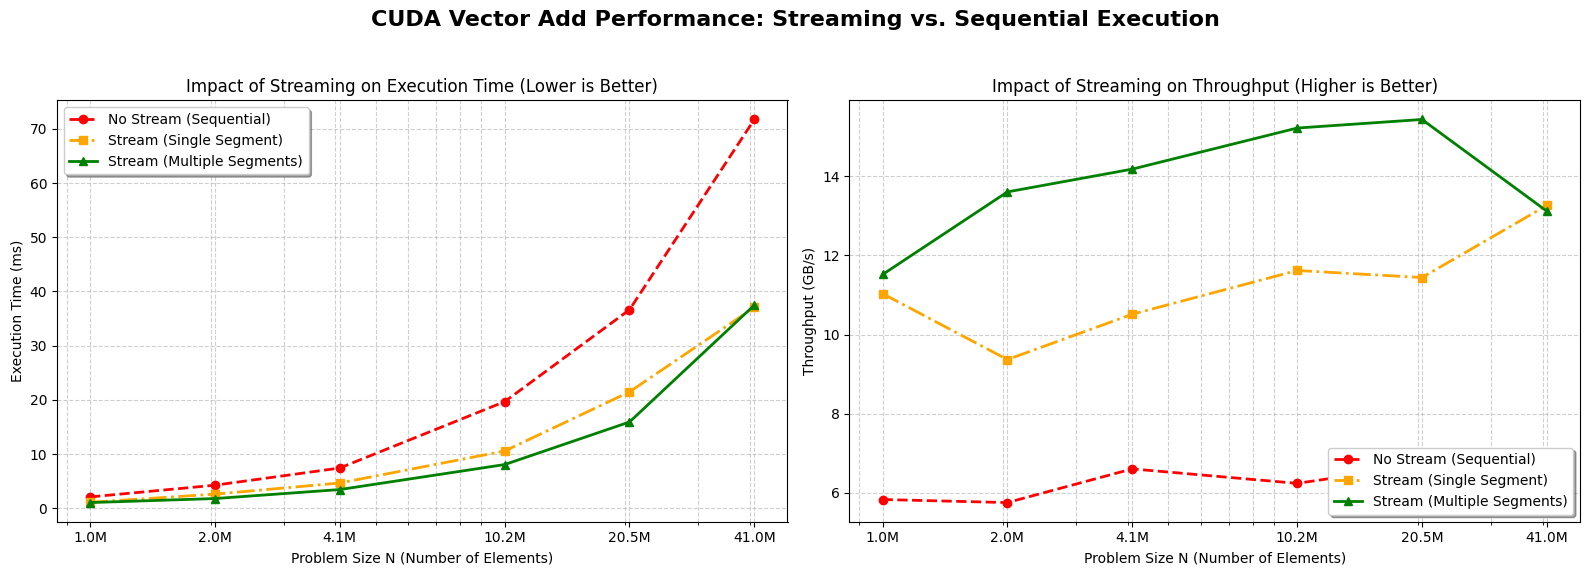


Data Analysis Summary:
----------------------
Max Problem Size (N=40,960,000)
  - Sequential Time: 71.726 ms
  - Tiled Stream Time: 37.478 ms
  -> Time reduction: 47.7%
-------------------------
  - Sequential Throughput: 6.853 GB/s
  - Tiled Stream Throughput: 13.115 GB/s
  -> Throughput gain: 91.4% (Speedup factor of 1.9x)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Data Extracted from User Output ---
# Note: The third scenario (Stream 2) uses 10 segments for N=1024000 and N=10240000,
# and N/10 segments for the other N values. We group them by the high-level strategy (Tiled Stream).
data = {
    'N': [
        1024000, 1024000, 1024000,
        2048000, 2048000, 2048000,
        4096000, 4096000, 4096000,
        10240000, 10240000, 10240000,
        20480000, 20480000, 20480000,
        40960000, 40960000, 40960000,
    ],
    'Scenario': [
        'No Stream (Sequential)', 'Stream (Single Segment)', 'Stream (Multiple Segments)',
        'No Stream (Sequential)', 'Stream (Single Segment)', 'Stream (Multiple Segments)',
        'No Stream (Sequential)', 'Stream (Single Segment)', 'Stream (Multiple Segments)',
        'No Stream (Sequential)', 'Stream (Single Segment)', 'Stream (Multiple Segments)',
        'No Stream (Sequential)', 'Stream (Single Segment)', 'Stream (Multiple Segments)',
        'No Stream (Sequential)', 'Stream (Single Segment)', 'Stream (Multiple Segments)',
    ],
    'Time_ms': [
        2.106, 1.114, 1.067,
        4.268, 2.623, 1.807,
        7.439, 4.676, 3.467,
        19.683, 10.578, 8.077,
        36.635, 21.485, 15.928,
        71.726, 37.069, 37.478, # Note: Tiled stream is slightly slower for max N, possibly due to segment overhead
    ],
    'Throughput_GBs': [
        5.835, 11.032, 11.516,
        5.758, 9.368, 13.601,
        6.608, 10.512, 14.176,
        6.243, 11.617, 15.213,
        6.708, 11.439, 15.429,
        6.853, 13.260, 13.115, # Throughput drops slightly here
    ]
}

df = pd.DataFrame(data)

# --- Plotting Functions ---

def create_performance_plots(dataframe):
    """Generates two plots: Execution Time and Throughput."""

    # Define colors and markers for consistency
    scenario_styles = {
        'No Stream (Sequential)': {'color': 'red', 'marker': 'o', 'linestyle': '--'},
        'Stream (Single Segment)': {'color': 'orange', 'marker': 's', 'linestyle': '-.'},
        'Stream (Multiple Segments)': {'color': 'green', 'marker': '^', 'linestyle': '-'},
    }

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot 1: Execution Time ---
    ax1 = axes[0]
    for scenario, style in scenario_styles.items():
        subset = dataframe[dataframe['Scenario'] == scenario]
        ax1.plot(
            subset['N'],
            subset['Time_ms'],
            label=scenario,
            color=style['color'],
            marker=style['marker'],
            linestyle=style['linestyle'],
            linewidth=2
        )

    ax1.set_xscale('log')
    ax1.set_xticks(np.unique(dataframe['N']))
    ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

    ax1.set_title('Impact of Streaming on Execution Time (Lower is Better)')
    ax1.set_xlabel('Problem Size N (Number of Elements)')
    ax1.set_ylabel('Execution Time (ms)')
    ax1.grid(True, which="both", ls="--", alpha=0.6)
    ax1.legend(loc='upper left', frameon=True, shadow=True)

    # --- Plot 2: Throughput ---
    ax2 = axes[1]
    for scenario, style in scenario_styles.items():
        subset = dataframe[dataframe['Scenario'] == scenario]
        ax2.plot(
            subset['N'],
            subset['Throughput_GBs'],
            label=scenario,
            color=style['color'],
            marker=style['marker'],
            linestyle=style['linestyle'],
            linewidth=2
        )

    ax2.set_xscale('log')
    ax2.set_xticks(np.unique(dataframe['N']))
    ax2.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

    ax2.set_title('Impact of Streaming on Throughput (Higher is Better)')
    ax2.set_xlabel('Problem Size N (Number of Elements)')
    ax2.set_ylabel('Throughput (GB/s)')
    ax2.grid(True, which="both", ls="--", alpha=0.6)
    ax2.legend(loc='lower right', frameon=True, shadow=True)

    # Final display settings
    plt.suptitle('CUDA Vector Add Performance: Streaming vs. Sequential Execution', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    create_performance_plots(df)

    print("\nData Analysis Summary:")
    print("----------------------")

    # Calculate performance gain for max N
    max_n_data = df[df['N'] == df['N'].max()]

    seq_time = max_n_data[max_n_data['Scenario'] == 'No Stream (Sequential)']['Time_ms'].iloc[0]
    tiled_time = max_n_data[max_n_data['Scenario'] == 'Stream (Multiple Segments)']['Time_ms'].iloc[0]

    time_improvement = (seq_time - tiled_time) / seq_time * 100

    seq_throughput = max_n_data[max_n_data['Scenario'] == 'No Stream (Sequential)']['Throughput_GBs'].iloc[0]
    tiled_throughput = max_n_data[max_n_data['Scenario'] == 'Stream (Multiple Segments)']['Throughput_GBs'].iloc[0]

    throughput_gain = (tiled_throughput - seq_throughput) / seq_throughput * 100

    print(f"Max Problem Size (N={df['N'].max():,})")
    print(f"  - Sequential Time: {seq_time:.3f} ms")
    print(f"  - Tiled Stream Time: {tiled_time:.3f} ms")
    print(f"  -> Time reduction: {time_improvement:.1f}%")
    print("-" * 25)
    print(f"  - Sequential Throughput: {seq_throughput:.3f} GB/s")
    print(f"  - Tiled Stream Throughput: {tiled_throughput:.3f} GB/s")
    print(f"  -> Throughput gain: {throughput_gain:.1f}% (Speedup factor of {tiled_throughput/seq_throughput:.1f}x)")

In [ ]:
!./vectorAdd_stream 1024000
!./vectorAdd_stream 1024000 1024
!./vectorAdd_stream 1024000 10240
!./vectorAdd_stream 1024000 102400
!printf "\n"
!./vectorAdd_stream 2048000
!./vectorAdd_stream 2048000 2048
!./vectorAdd_stream 2048000 20480
!./vectorAdd_stream 2048000 204800
!printf "\n"
!./vectorAdd_stream 40960000
!./vectorAdd_stream 40960000 2048
!./vectorAdd_stream 40960000 20480
!./vectorAdd_stream 40960000 204800
!printf "\n"


Stream: Configuration: N=1024000, Segment Size (S_seg)=1024000, Num Segments=1, Num Streams=4
Quick check at index 512000: h_c[512000] = 1536000. Seems OK.
Execution Time: 1.391 ms, Throughput: 8.834 GB/s (736.191 Melem/s)

Stream: Configuration: N=1024000, Segment Size (S_seg)=1024, Num Segments=1000, Num Streams=4
Quick check at index 512000: h_c[512000] = 1536000. Seems OK.
Execution Time: 8.718 ms, Throughput: 1.409 GB/s (117.457 Melem/s)

Stream: Configuration: N=1024000, Segment Size (S_seg)=10240, Num Segments=100, Num Streams=4
Quick check at index 512000: h_c[512000] = 1536000. Seems OK.
Execution Time: 1.903 ms, Throughput: 6.458 GB/s (538.195 Melem/s)

Stream: Configuration: N=1024000, Segment Size (S_seg)=102400, Num Segments=10, Num Streams=4
Quick check at index 512000: h_c[512000] = 1536000. Seems OK.
Execution Time: 1.221 ms, Throughput: 10.067 GB/s (838.904 Melem/s)


Stream: Configuration: N=2048000, Segment Size (S_seg)=2048000, Num Segments=1, Num Streams=4
Quick c

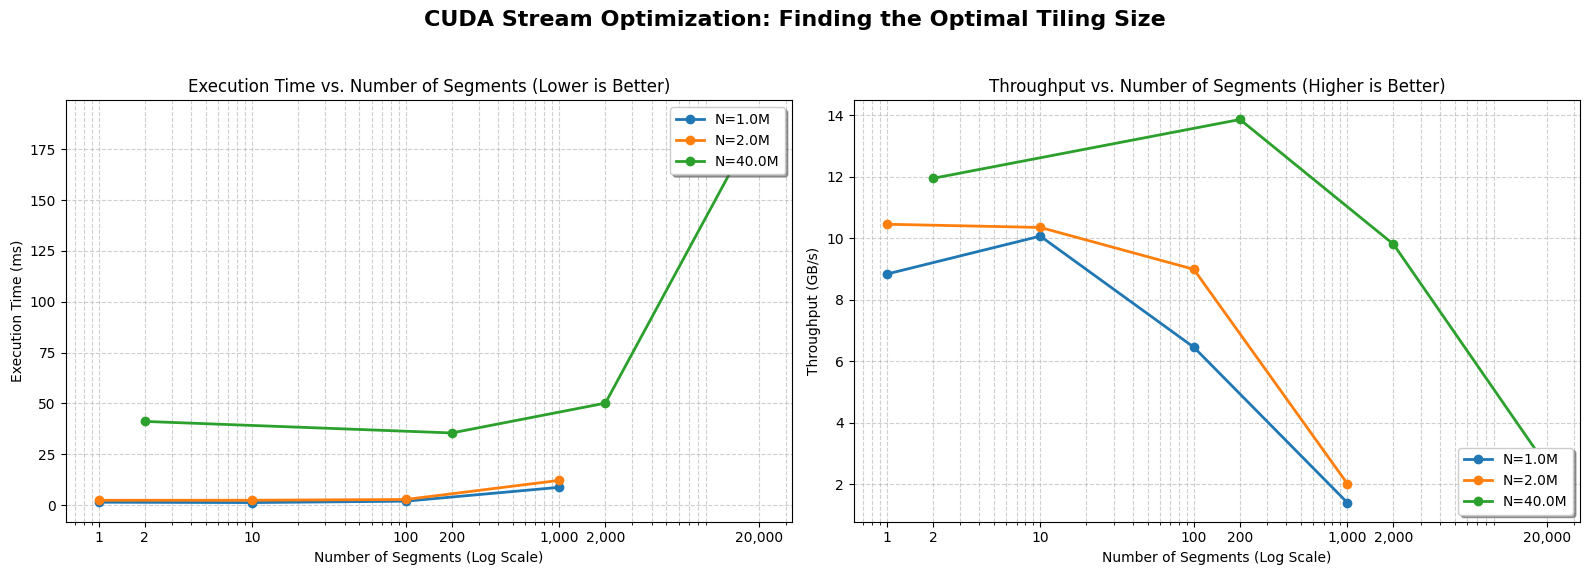


Data Analysis Summary:
----------------------

Problem Size N = 1,024,000
  - Optimal Configuration (Lowest Time): 1.221 ms with 10 segments.
  - Worst Configuration (Highest Time): 8.718 ms with 1,000 segments.
  -> Performance difference: 614.0%

Problem Size N = 2,048,000
  - Optimal Configuration (Lowest Time): 2.351 ms with 1 segments.
  - Worst Configuration (Highest Time): 12.137 ms with 1,000 segments.
  -> Performance difference: 416.2%

Problem Size N = 40,960,000
  - Optimal Configuration (Lowest Time): 35.471 ms with 200 segments.
  - Worst Configuration (Highest Time): 189.687 ms with 20,000 segments.
  -> Performance difference: 434.8%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- New Data Extracted from User Output ---
# This data shows the performance (Time and Throughput) when varying the
# number of segments (tiling size) for three fixed problem sizes (N).
# The goal is to find the sweet spot for maximum overlap and minimum overhead.
data = {
    'N': [
        1024000, 1024000, 1024000, 1024000,
        2048000, 2048000, 2048000, 2048000,
        40960000, 40960000, 40960000, 40960000,
    ],
    'Num_Segments': [
        1, 1000, 100, 10,
        1, 1000, 100, 10,
        2, 20000, 2000, 200,
    ],
    'Time_ms': [
        1.391, 8.718, 1.903, 1.221,
        2.351, 12.137, 2.734, 2.375,
        41.148, 189.687, 50.146, 35.471,
    ],
    'Throughput_GBs': [
        8.834, 1.409, 6.458, 10.067,
        10.453, 2.025, 8.989, 10.349,
        11.945, 2.591, 9.802, 13.857,
    ]
}

df = pd.DataFrame(data)

# Sort the data by N and then by Num_Segments to ensure lines plot correctly
df = df.sort_values(by=['N', 'Num_Segments'], ascending=[True, True])

# --- Plotting Functions ---

def create_optimization_plots(dataframe):
    """Generates two plots showing performance vs. number of segments."""

    # Map N values to human-readable labels for the legend
    n_labels = {
        1024000: 'N=1.0M',
        2048000: 'N=2.0M',
        40960000: 'N=40.0M',
    }
    dataframe['N_Label'] = dataframe['N'].map(n_labels)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot 1: Execution Time vs. Number of Segments ---
    ax1 = axes[0]
    for n_value, label in n_labels.items():
        subset = dataframe[dataframe['N'] == n_value]
        ax1.plot(
            subset['Num_Segments'],
            subset['Time_ms'],
            label=label,
            marker='o',
            linewidth=2
        )

    ax1.set_xscale('log')
    # Use custom ticks to display all data points clearly
    unique_segments = np.unique(dataframe['Num_Segments']).tolist()
    ax1.set_xticks(unique_segments)
    ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x):,}'))

    ax1.set_title('Execution Time vs. Number of Segments (Lower is Better)')
    ax1.set_xlabel('Number of Segments (Log Scale)')
    ax1.set_ylabel('Execution Time (ms)')
    ax1.grid(True, which="both", ls="--", alpha=0.6)
    ax1.legend(loc='upper right', frameon=True, shadow=True)

    # --- Plot 2: Throughput vs. Number of Segments ---
    ax2 = axes[1]
    for n_value, label in n_labels.items():
        subset = dataframe[dataframe['N'] == n_value]
        ax2.plot(
            subset['Num_Segments'],
            subset['Throughput_GBs'],
            label=label,
            marker='o',
            linewidth=2
        )

    ax2.set_xscale('log')
    ax2.set_xticks(unique_segments)
    ax2.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x):,}'))

    ax2.set_title('Throughput vs. Number of Segments (Higher is Better)')
    ax2.set_xlabel('Number of Segments (Log Scale)')
    ax2.set_ylabel('Throughput (GB/s)')
    ax2.grid(True, which="both", ls="--", alpha=0.6)
    ax2.legend(loc='lower right', frameon=True, shadow=True)

    # Final display settings
    plt.suptitle('CUDA Stream Optimization: Finding the Optimal Tiling Size', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    create_optimization_plots(df)

    print("\nData Analysis Summary:")
    print("----------------------")

    for n_val in sorted(df['N'].unique()):
        subset = df[df['N'] == n_val]

        best_time_row = subset.loc[subset['Time_ms'].idxmin()]
        worst_time_row = subset.loc[subset['Time_ms'].idxmax()]

        print(f"\nProblem Size N = {n_val:,}")
        print(f"  - Optimal Configuration (Lowest Time): {best_time_row['Time_ms']:.3f} ms with {best_time_row['Num_Segments']:,} segments.")
        print(f"  - Worst Configuration (Highest Time): {worst_time_row['Time_ms']:.3f} ms with {worst_time_row['Num_Segments']:,} segments.")

        time_diff = (worst_time_row['Time_ms'] - best_time_row['Time_ms']) / best_time_row['Time_ms'] * 100
        print(f"  -> Performance difference: {time_diff:.1f}%")

In [ ]:
!nvprof --output-profile profile_mycode2.nvprof ./vectorAdd 1024000

==8817== NVPROF is profiling process 8817, command: ./vectorAdd 1024000
Configuration: N=1024000, blocks=8000, threads_per_block=128, total_threads=1024000, extra_threads=0
All 1024000 results match. OK
Execution Time: 2.063 ms, throughput: 5.955 GB/s (496.286 Melem/s)
==8817== Generated result file: /content/profile_mycode2.nvprof


In [ ]:
!printf "\n"
!./vectorAdd_stream 40960000 1024
!./vectorAdd_stream 40960000 2048
!./vectorAdd_stream 40960000 4096
!./vectorAdd_stream 40960000 10240
!./vectorAdd_stream 40960000 20480
!./vectorAdd_stream 40960000 40960
!./vectorAdd_stream 40960000 102400
!./vectorAdd_stream 40960000 204800
!./vectorAdd_stream 40960000 409600
!printf "\n"



Stream: Configuration: N=40960000, Segment Size (S_seg)=1024, Num Segments=40000, Num Streams=4
Quick check at index 20480000: h_c[20480000] = 61440000. Seems OK.
Execution Time: 376.826 ms, Throughput: 1.304 GB/s (108.697 Melem/s)

Stream: Configuration: N=40960000, Segment Size (S_seg)=2048, Num Segments=20000, Num Streams=4
Quick check at index 20480000: h_c[20480000] = 61440000. Seems OK.
Execution Time: 209.527 ms, Throughput: 2.346 GB/s (195.488 Melem/s)

Stream: Configuration: N=40960000, Segment Size (S_seg)=4096, Num Segments=10000, Num Streams=4
Quick check at index 20480000: h_c[20480000] = 61440000. Seems OK.
Execution Time: 137.961 ms, Throughput: 3.563 GB/s (296.894 Melem/s)

Stream: Configuration: N=40960000, Segment Size (S_seg)=10240, Num Segments=4000, Num Streams=4
Quick check at index 20480000: h_c[20480000] = 61440000. Seems OK.
Execution Time: 60.342 ms, Throughput: 8.146 GB/s (678.795 Melem/s)

Stream: Configuration: N=40960000, Segment Size (S_seg)=20480, Num 

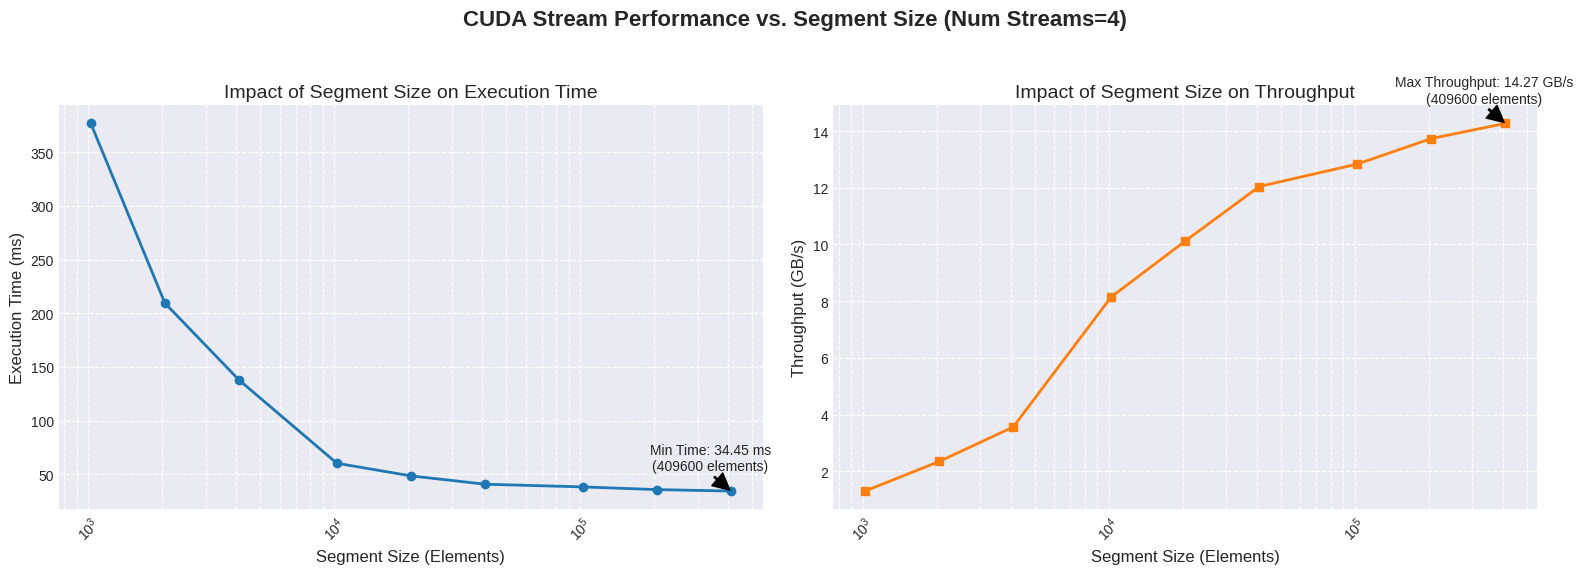

Plot generation complete. The charts illustrate how increasing the segment size (S_seg) improves performance by reducing stream overhead, leading to lower execution time and higher throughput.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Extracted Data ---
# Data extracted from the nvprof output (Segment Size is the independent variable)

# Segment Size (S_seg) in elements
segment_sizes = np.array([
    1024,
    2048,
    4096,
    10240,
    20480,
    40960,
    102400,
    204800,
    409600
])

# Execution Time in milliseconds (ms)
execution_times_ms = np.array([
    376.826,
    209.527,
    137.961,
    60.342,
    48.583,
    40.818,
    38.300,
    35.791,
    34.450
])

# Throughput in Gigabytes per second (GB/s)
throughput_gbs = np.array([
    1.304,
    2.346,
    3.563,
    8.146,
    10.117,
    12.042,
    12.833,
    13.733,
    14.268
])

# --- 2. Plotting Setup ---
plt.style.use('seaborn-v0_8-darkgrid') # Use a nice, modern style

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('CUDA Stream Performance vs. Segment Size (Num Streams=4)', fontsize=16, fontweight='bold')

# --- 3. Plot 1: Execution Time vs. Segment Size ---
ax1 = axes[0]
ax1.plot(segment_sizes, execution_times_ms, marker='o', linestyle='-', color='#1f77b4', linewidth=2)
ax1.set_xscale('log') # Use logarithmic scale for x-axis as values span a wide range
ax1.set_xlabel('Segment Size (Elements)', fontsize=12)
ax1.set_ylabel('Execution Time (ms)', fontsize=12)
ax1.set_title('Impact of Segment Size on Execution Time', fontsize=14)
ax1.grid(True, which="both", ls="--")
ax1.tick_params(axis='x', rotation=45)

# Annotate the minimum time point
min_time_index = np.argmin(execution_times_ms)
ax1.annotate(
    f'Min Time: {execution_times_ms[min_time_index]:.2f} ms\n({segment_sizes[min_time_index]} elements)',
    (segment_sizes[min_time_index], execution_times_ms[min_time_index]),
    textcoords="offset points",
    xytext=(-15, 15),
    ha='center',
    arrowprops=dict(facecolor='black', shrink=0.05, width=1)
)


# --- 4. Plot 2: Throughput vs. Segment Size ---
ax2 = axes[1]
ax2.plot(segment_sizes, throughput_gbs, marker='s', linestyle='-', color='#ff7f0e', linewidth=2)
ax2.set_xscale('log') # Use logarithmic scale for x-axis
ax2.set_xlabel('Segment Size (Elements)', fontsize=12)
ax2.set_ylabel('Throughput (GB/s)', fontsize=12)
ax2.set_title('Impact of Segment Size on Throughput', fontsize=14)
ax2.grid(True, which="both", ls="--")
ax2.tick_params(axis='x', rotation=45)

# Annotate the maximum throughput point
max_throughput_index = np.argmax(throughput_gbs)
ax2.annotate(
    f'Max Throughput: {throughput_gbs[max_throughput_index]:.2f} GB/s\n({segment_sizes[max_throughput_index]} elements)',
    (segment_sizes[max_throughput_index], throughput_gbs[max_throughput_index]),
    textcoords="offset points",
    xytext=(-15, 15),
    ha='center',
    arrowprops=dict(facecolor='black', shrink=0.05, width=1)
)

# --- 5. Final Display ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

print("Plot generation complete. The charts illustrate how increasing the segment size (S_seg) improves performance by reducing stream overhead, leading to lower execution time and higher throughput.")